In [1]:
import json
import functools
import multiprocessing
from pathlib import Path

import numpy as np
import numpy.linalg
import pandas as pd
import scipy as sp
import scipy.optimize
from matplotlib import pyplot as plt

from helper import (
    get_station_data, 
    get_train_test_time_ranges,
    evaluate_markov_chain,
    calculate_n_ijh, calculate_p_ijh
)

In [2]:
province='AB'
#province='BC'
# province='MB'
#province='NB'
#province='NL'
#province='NS'
#province='NT'
#province='NU'
# province='ON'
#province='PE'
#province='QC'
#province='SK'
#province='YT'

# station_id_set = set(['6158355', '6158359'])
station_id_set = set(['3034479', '3034485'])

In [3]:
raw_data_base_dir = Path('raw-data')

In [4]:
df = get_station_data(
    raw_data_base_dir / province,
    station_id_set=station_id_set,
)

In [5]:
len(df)

311253

In [6]:
group = df.groupby('Climate ID')
display(group.count().rsub(group.size(), axis=0))

,Longitude (x),Latitude (y),Station Name,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
Climate ID,,,,,,,,,,
3034479,0,0,0,0,0,0,0,0,9405,1289
3034485,0,0,0,0,0,0,0,0,9609,915


In [7]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
0,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 15:00:00,2001,1,12,15:00,2.0,13.0
1,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 16:00:00,2001,1,12,16:00,1.0,11.0
2,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 17:00:00,2001,1,12,17:00,2.0,9.0
3,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 18:00:00,2001,1,12,18:00,2.0,9.0
4,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 19:00:00,2001,1,12,19:00,3.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
311248,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 21:00:00,2023,8,18,21:00,34.0,19.0
311249,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 22:00:00,2023,8,18,22:00,29.0,18.0
311250,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 22:00:00,2023,8,18,22:00,31.0,15.0
311251,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 23:00:00,2023,8,18,23:00,29.0,26.0


In [8]:
direction_mask = (
    (~df['Wind Spd (km/h)'].isna())
    *
    (~df['Wind Dir (10s deg)'].isna())
    *
    (df['Wind Dir (10s deg)'] > (degree_tol := 0.1))
)

In [9]:
deca_degree_to_rad = 10 * np.pi / 180

for deca_degree in [0, 9, 18, 27, 36]:
    print(f'{deca_degree=}')
    print('N/S: {}'.format(np.cos(deca_degree * deca_degree_to_rad)))
    print('E/W: {}'.format(np.sin(deca_degree * deca_degree_to_rad)))
    print()

deca_degree=0
N/S: 1.0
E/W: 0.0

deca_degree=9
N/S: 6.123233995736766e-17
E/W: 1.0

deca_degree=18
N/S: -1.0
E/W: 1.2246467991473532e-16

deca_degree=27
N/S: -1.8369701987210297e-16
E/W: -1.0

deca_degree=36
N/S: 1.0
E/W: -2.4492935982947064e-16



In [10]:
df.loc[direction_mask, 'Wind Spd N/S'] = (
    df.loc[direction_mask, 'Wind Spd (km/h)']
    *
    np.cos(
        df.loc[direction_mask, 'Wind Dir (10s deg)'] * deca_degree_to_rad
    )
)
df.loc[direction_mask, 'Wind Spd E/W'] = (
    df.loc[direction_mask, 'Wind Spd (km/h)']
    *
    np.sin(
        df.loc[direction_mask, 'Wind Dir (10s deg)'] * deca_degree_to_rad
    )
)

df.loc[~direction_mask, ['Wind Spd N/S', 'Wind Spd E/W']] = np.nan

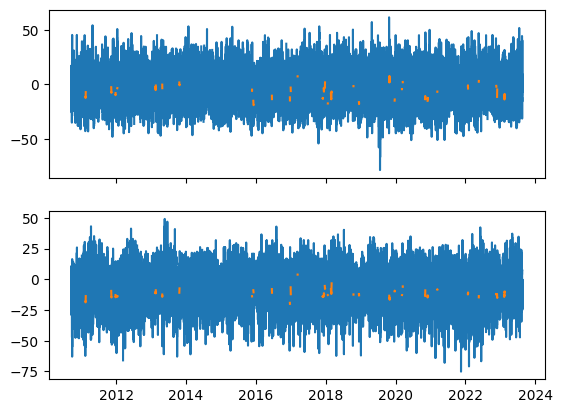

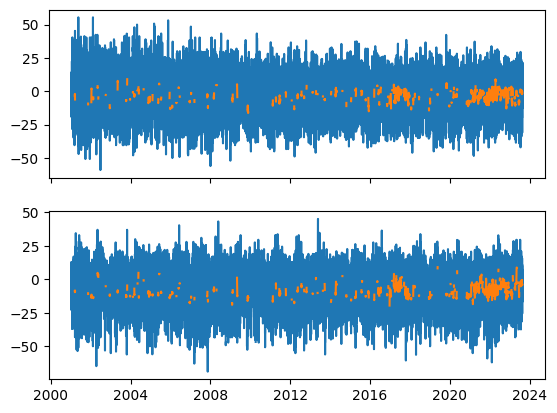

In [11]:
roll_window = 24*7

for index, sub_df in df.groupby('Climate ID'):
    fig, (ax_i1, ax_i2) = plt.subplots(nrows=2, sharex=True)
    ax_i1.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd N/S'],
        label='Moving Average',
    )
    ax_i1.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd N/S'].rolling(roll_window).mean(),
        label='Moving Average',
    )
    ax_i2.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd E/W'],
        label='Moving Average',
    )
    ax_i2.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd E/W'].rolling(roll_window).mean(),
        label='Moving Average',
    )
plt.show()

Climate ID
3034479    Axes(0.125,0.11;0.775x0.77)
3034485    Axes(0.125,0.11;0.775x0.77)
Name: Wind Spd N/S, dtype: object

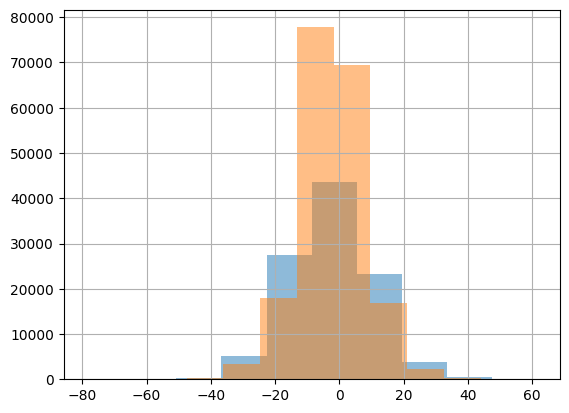

In [12]:
df.groupby('Climate ID')['Wind Spd N/S'].hist(alpha=0.5)

Climate ID
3034479    Axes(0.125,0.11;0.775x0.77)
3034485    Axes(0.125,0.11;0.775x0.77)
Name: Wind Spd E/W, dtype: object

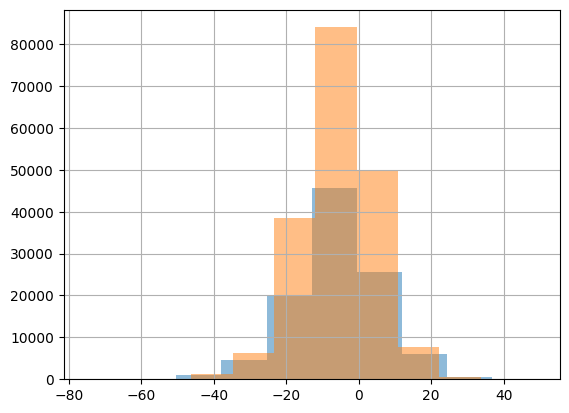

In [13]:
df.groupby('Climate ID')['Wind Spd E/W'].hist(alpha=0.5)

In [14]:
max_single_unsigned_state = 1
state_bin_size = 20

df['Wind Spd N/S State'] = df['Wind Spd N/S'] // state_bin_size
df['Wind Spd E/W State'] = df['Wind Spd E/W'] // state_bin_size

df['Wind Spd N/S State'].clip(lower=-max_single_unsigned_state-1, upper=max_single_unsigned_state, inplace=True)
df['Wind Spd E/W State'].clip(lower=-max_single_unsigned_state-1, upper=max_single_unsigned_state, inplace=True)

df['Wind Spd N/S State'] += max_single_unsigned_state+1
df['Wind Spd E/W State'] += max_single_unsigned_state+1

max_directional_state = 2*(max_single_unsigned_state+1)
df['Wind Spd State'] = df['Wind Spd N/S State'] + max_directional_state*df['Wind Spd E/W State']

df.loc[:,'Wind Spd State'] = df['Wind Spd State'].astype('Int16')

In [15]:
df['Wind Spd N/S State'].min()

0.0

In [16]:
df['Wind Spd N/S State'].max()

3.0

In [17]:
df['Wind Spd N/S State'].unique().size

5

In [18]:
df['Wind Spd E/W State'].min()

0.0

In [19]:
df['Wind Spd E/W State'].max()

3.0

In [20]:
df['Wind Spd E/W State'].unique().size

5

In [21]:
df['Wind Spd State'].min()

0

In [22]:
df['Wind Spd State'].max()

15

In [23]:
max_location_state = max_directional_state ** 2
display(max_location_state)

16

Climate ID
3034479    Axes(0.125,0.11;0.775x0.77)
3034485    Axes(0.125,0.11;0.775x0.77)
Name: Wind Spd State, dtype: object

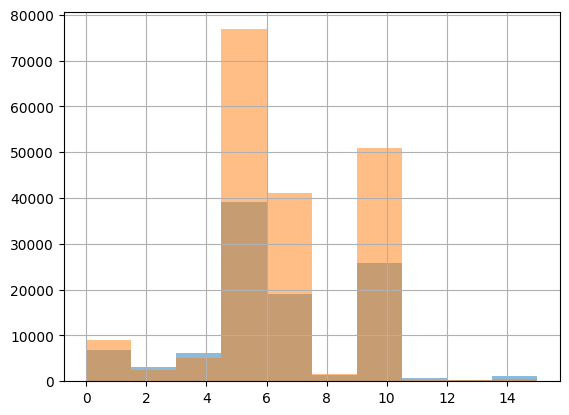

In [24]:
df.groupby('Climate ID')['Wind Spd State'].hist(alpha=0.5)

In [25]:
ts_dfs = []
for index, sub_df in df.groupby(by='Climate ID'):
    ts_df = sub_df[['Date/Time (LST)', 'Wind Spd State']]
    ts_df = (
        ts_df
        .set_index('Date/Time (LST)')
        .rename(
            columns={
                colname: f'{index} - {colname}'
                for colname in ts_df.columns
            },
        )
    )
    ts_dfs.append(ts_df)

ts_df = pd.concat(ts_dfs, ignore_index=False, axis='columns')
display(ts_df)

,3034479 - Wind Spd State,3034485 - Wind Spd State
Date/Time (LST),,
2001-01-12 15:00:00,<NA>,10
2001-01-12 16:00:00,<NA>,10
2001-01-12 17:00:00,<NA>,10
2001-01-12 18:00:00,<NA>,10
2001-01-12 19:00:00,<NA>,10
...,...,...
2023-08-18 19:00:00,7,7
2023-08-18 20:00:00,7,6
2023-08-18 21:00:00,7,6


In [26]:
ts_df['Wind Spd Multi-State'] = ts_df.iloc[:, 0] + max_location_state*ts_df.iloc[:, 1]

In [27]:
max_multi_state_val = (max_location_state)**2
display(max_multi_state_val)

256

In [33]:
ts_df['Wind Spd Multi-State'].min()

0

In [34]:
ts_df['Wind Spd Multi-State'].max()

239

<Axes: >

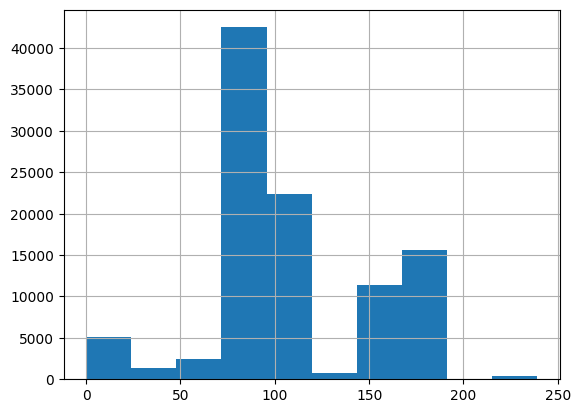

In [28]:
ts_df['Wind Spd Multi-State'].hist()

In [29]:
def objective_func(xx, p_ijh=None, weights=None):
    num_elements = xx.size
    side = int(np.sqrt(num_elements))
    matrix = xx.reshape(side,side)

    delta_matrices = [
        pij_h - matrix**hh
        for hh, pij_h  in enumerate(p_ijh, start=1)
    ]

    if weights is None:
        weights = np.array([1/len(delta_matrices) for _ in delta_matrices])

    delta_scores = np.array([
        np.linalg.norm(d_mat)
        for d_mat in delta_matrices
    ])
    score = np.sum(weights * delta_scores)

    return score

In [30]:
results = []
for idx,(train_range, test_range) in enumerate(get_train_test_time_ranges()):
    train_start, train_end = train_range
    test_start, test_range = train_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)
    test_mask = ts_df.index.map(lambda time_idx: time_idx >= test_start and time_idx <= test_range)

    train_state_ts = ts_df.loc[train_mask, 'Wind Spd Multi-State']
    test_state_ts = ts_df.loc[test_mask, 'Wind Spd Multi-State']

    n_ijh = calculate_n_ijh(train_state_ts)
    p_ijh = calculate_p_ijh(
        train_state_ts, n_ijh,
        min_state=0, 
        max_state=max_multi_state_val-1,
    )

    result = sp.optimize.minimize(
        fun=functools.partial(
            objective_func,
            p_ijh=p_ijh,
            # weights=None,
        ),
        x0=np.ravel(p_ijh[0]) if len(results) == 0 else results[-1].x,
    )
    print(result)
    results.append(result)

    with open(f'markov-chain-with-direction-{idx}.json', 'w') as flink:
        json.dump(list(result.x), flink)


MemoryError: Unable to allocate 32.5 GiB for an array with shape (66049, 66049) and data type float64

In [ ]:
test_df['Wind Spd Multi-State']

In [ ]:
for (train_range, test_range), result in zip(get_train_test_time_ranges(),results):
    train_start, train_end = train_range
    test_start, test_range = train_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)
    test_mask = ts_df.index.map(lambda time_idx: time_idx >= test_start and time_idx <= test_range)

    train_df = ts_df[train_mask]
    test_df = ts_df[test_mask]

    forcast_series = evaluate_markov_chain(
        test_df['Wind Spd Multi-State'],
        transition_matrix_vec=result.x,
        vec_size=max_multi_state_val,
        max_iter=100,
    )

    import ipdb;ipdb.set_trace()

    # test_score = objective_func(result.x, train_df=test_df)
    # train_rsm = np.sqrt(result.fun / len(train_df))
    # test_rms = np.sqrt(test_score/len(test_df))

    # display(result)
    # print(f'{train_rsm=}')
    # print(f'{test_score=}')
    # print(f'{test_rms=}')
    # print()
